# Neural network

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables

warnings.simplefilter("ignore")

start = time()
## Fetching data
database_path = Path(os.path.abspath('')).parent / "../datasets/database.sqlite"
conn = sqlite3.connect(database_path)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

match_data_rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id",
                   "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
                   "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7",
                   "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
                   "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
                   "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]

# Construct SQL to select only rows with data
match_data_sql = 'SELECT * FROM MATCH' + ' WHERE ' + " IS NOT NULL AND ".join(match_data_rows) + ';'

match_data = pd.read_sql(match_data_sql, conn)

# Comment in if you don't want to use the entire match data
# match_data = match_data.tail(10000)

#Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']
feables = create_feables(match_data, None, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

# Labels and features
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)



Generating match features...
Match features generated in 11.6 minutes
Generating match labels...
Match labels generated in 0.8 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


In [2]:
from sklearn.model_selection import train_test_split


#Splitting the data into train, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)

# Show some rows of the data
X_train.head()

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_1.0,League_1729.0,League_4769.0,League_7809.0,...,League_17642.0,League_19694.0,League_21518.0,League_24558.0,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
14958,-10.0,-13.0,3.0,2.0,1.0,0.0,0,0,0,0,...,1,0,0,0,0.489607,0.287738,0.222655,0.484795,0.289362,0.225843
3769,7.0,3.0,4.0,5.0,0.0,1.0,0,1,0,0,...,0,0,0,0,0.335407,0.294752,0.369841,0.343402,0.300477,0.356121
16879,3.0,-5.0,5.0,2.0,1.0,1.0,0,0,0,0,...,0,1,0,0,0.447368,0.276316,0.276316,0.432193,0.292776,0.275032
16105,-5.0,-2.0,0.0,1.0,0.0,0.0,0,0,0,0,...,0,1,0,0,0.397686,0.286816,0.315498,0.428325,0.276764,0.294912
17090,-5.0,2.0,4.0,3.0,1.0,0.0,0,0,0,0,...,0,1,0,0,0.285714,0.285714,0.428571,0.302926,0.283993,0.413081


In [3]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 1 = win
# 0 = draw
# -1 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])


Number of possible outcomes 3


In [4]:
# Get number of columns by tacking the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 23


In [7]:
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Input, Activation, Flatten, Dense, Concatenate, Dropout
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

def build_model():
    model = Sequential()
    model.add(Dense(32, input_dim=columns, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0002)))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['accuracy']) # categorical_crossentropy
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 27        
Total params: 1,459
Trainable params: 1,459
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.utils.np_utils import to_categorical

categorical = to_categorical(y_train, num_classes=3)
history = model.fit(X_train, categorical, batch_size=32, epochs=100, validation_split=0.1)



Train on 13278 samples, validate on 1476 samples
Epoch 1/100
13278/13278 [==============================] - 2s 184us/step - loss: 0.2598 - acc: 0.3948 - val_loss: 0.2315 - val_acc: 0.4614
Epoch 2/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.2207 - acc: 0.4805 - val_loss: 0.2157 - val_acc: 0.4932
Epoch 3/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.2145 - acc: 0.4971 - val_loss: 0.2131 - val_acc: 0.4973
Epoch 4/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.2127 - acc: 0.4995 - val_loss: 0.2117 - val_acc: 0.5000
Epoch 5/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.2114 - acc: 0.5038 - val_loss: 0.2108 - val_acc: 0.4986
Epoch 6/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.2105 - acc: 0.5047 - val_loss: 0.2102 - val_acc: 0.5075
Epoch 7/100
13278/13278 [==============================] - 1s 65us/step - loss: 0.2097 - acc: 0.5064 - val_loss: 0.2096 

Epoch 57/100
13278/13278 [==============================] - 1s 73us/step - loss: 0.1984 - acc: 0.5306 - val_loss: 0.1999 - val_acc: 0.5278
Epoch 58/100
13278/13278 [==============================] - 1s 67us/step - loss: 0.1984 - acc: 0.5293 - val_loss: 0.1998 - val_acc: 0.5264
Epoch 59/100
13278/13278 [==============================] - 1s 70us/step - loss: 0.1983 - acc: 0.5319 - val_loss: 0.1998 - val_acc: 0.5318
Epoch 60/100
13278/13278 [==============================] - 1s 66us/step - loss: 0.1982 - acc: 0.5310 - val_loss: 0.2000 - val_acc: 0.5285
Epoch 61/100
13278/13278 [==============================] - 1s 95us/step - loss: 0.1982 - acc: 0.5340 - val_loss: 0.1998 - val_acc: 0.5224
Epoch 62/100
13278/13278 [==============================] - 1s 91us/step - loss: 0.1981 - acc: 0.5307 - val_loss: 0.1996 - val_acc: 0.5271
Epoch 63/100
13278/13278 [==============================] - 1s 70us/step - loss: 0.1980 - acc: 0.5305 - val_loss: 0.2002 - val_acc: 0.5224
Epoch 64/100
13278/13278 [=

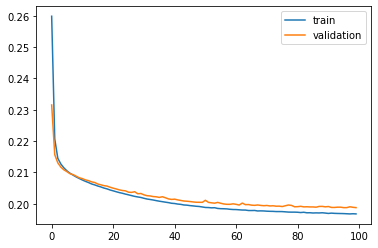

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

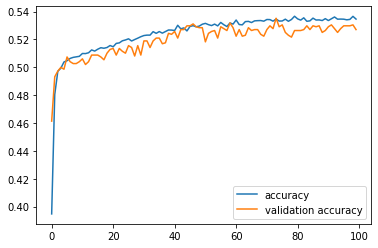

In [13]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [33]:
# Take the most probable prediction
predictions = np.argmax(model.predict(X_test), axis=1)
# Calculate accuracy
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

Test set accuracy: 0.5320187029884123


# Let us plot the confusion matrix

In [72]:
# from utils.data_processing import build_confusion_matrix

# TODO: Remove this and use the commented import instead
def build_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[2, 1, 0]),
                        index=['Home wins (true)', 'Draw (true)', 'Away wins (true)'],
                        columns=['Home wins (pred)', 'Draw (pred)', 'Away wins (pred)'])


print("Neural network confusion matrix: \n", build_confusion_matrix(y_test, predictions))

Neural network confusion matrix: 
                   Home wins (pred)  Draw (pred)  Away wins (pred)
Home wins (true)              1915            0               344
Draw (true)                    908            0               334
Away wins (true)               716            0               702


# Comparing Neural network to Random forest

In [61]:
#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0, stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.25, random_state = 0, stratify = y_train_calibrate)


In [65]:
from utils.data_processing import train_calibrate_predict

# Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

# Init Random Forest
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 'dm_reduce__n_components': np.arange(5, feature_len, int(np.around(feature_len/5)))}

#Initializing dimensionality reductions
pca = PCA()
RF_clf.fit(X_train, y_train)

print("Random forest accuracy for train set.".format(RF_clf.__class__.__name__, accuracy_score(y_train, RF_clf.predict(X_train))))
print("Random forest accuracy for test set".format(RF_clf.__class__.__name__, accuracy_score(y_test, RF_clf.predict(X_test))))

#Grid search, calibrate, and test the classifier
calibrated_RF_clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = RF_clf, dm_reduction = pca, X_train = X_train, y_train = y_train,
                                                                  X_calibrate = X_calibrate, y_calibrate = y_calibrate,
                                                                  X_test = X_test, y_test = y_test, cv_sets = cv_sets,
                                                                  params = parameters_RF, scorer = scorer, jobs = 1, use_grid_search = True)

Random forest accuracy for train set.
Random forest accuracy for test set
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 4.1 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.4365 seconds
Score of CalibratedClassifierCV for training set: 0.9898.
Made predictions in 0.1943 seconds
Score of CalibratedClassifierCV for test set: 0.5125.
Made predictions in 0.4079 seconds
Made predictions in 0.2170 seconds


In [75]:
rf_predictions = RF_clf.predict(X_test)

# Calculate accuracy
accuracy = (rf_predictions == y_test).mean()
print("Random forest test set accuracy:", accuracy)

Random forest test set accuracy: 0.5122992478145965


In [76]:
print("Random forest confusion matrix: \n", build_confusion_matrix(y_test, rf_predictions))

Random forest confusion matrix: 
                   Home wins (pred)  Draw (pred)  Away wins (pred)
Home wins (true)              1747          144               368
Draw (true)                    787          120               335
Away wins (true)               628          137               653


# Conclusion